In [1]:
import numpy as np
import pandas as pd
import random
from scipy.spatial import distance
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def cosine_similarity(x1, x2):
    dot_product = np.dot(x1, x2)
    norm_x1 = np.linalg.norm(x1)
    norm_x2 = np.linalg.norm(x2)
    return 1 - (dot_product / (norm_x1 * norm_x2))

def jaccard_similarity(x1, x2):
    intersection = np.sum(np.minimum(x1, x2))
    union = np.sum(np.maximum(x1, x2))
    return 1 - (intersection / union)

def calculate_sse(X, centroids, clusters):
    sse = 0
    for i, centroid in enumerate(centroids):
        cluster_points = X[clusters[i]]
        sse += np.sum((cluster_points - centroid) ** 2)
    return sse

<h1>Q1</h1>

In [3]:
data = pd.read_csv("data.csv")
X = data.values

labels = pd.read_csv("label.csv")
true_labels = labels.values
true_labels_flatten = true_labels.flatten()

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

k_label = len(labels['7'].unique())
random.seed(42)

In [4]:
def kmeans(X, k, similarity_measure='euclidean', max_iters=100):
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    clusters = [[] for _ in range(k)]

    for _ in range(max_iters):
        labels = []
        for i, x in enumerate(X):
            distances = [euclidean_distance(x, centroid) if similarity_measure == 'euclidean'
                         else cosine_similarity(x, centroid) if similarity_measure == 'cosine'
                         else jaccard_similarity(x, centroid) for centroid in centroids]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(i)
            labels.append(cluster_idx)

        for j, cluster in enumerate(clusters):
            if len(cluster) == 0:
                continue
            cluster_points = X[cluster]
            centroids[j] = np.mean(cluster_points, axis=0)

    return centroids, clusters, labels

In [5]:
euclidean_centroids, euclidean_clusters, euclidean_labels = kmeans(X, k=k_label, similarity_measure='euclidean', max_iters=100)
euclidean_sse = calculate_sse(X, euclidean_centroids, euclidean_clusters)
print("SSE for Euclidean K-means:", euclidean_sse)

cosine_centroids, cosine_clusters, cosine_labels = kmeans(X, k=k_label, similarity_measure='cosine', max_iters=100)
cosine_sse = calculate_sse(X, cosine_centroids, cosine_clusters)
print("SSE for Cosine K-means:", cosine_sse)

jaccard_centroids, jaccard_clusters, jaccard_labels = kmeans(X, k=k_label, similarity_measure='jaccard', max_iters=100)
jaccard_sse = calculate_sse(X, jaccard_centroids, jaccard_clusters)
print("SSE for Jaccard K-means:", jaccard_sse)

SSE for Euclidean K-means: 2583579141024
SSE for Cosine K-means: 2612134635345
SSE for Jaccard K-means: 2588522739078


<h1>Q2</h1>

In [6]:
def majority_votes_label(label, true_labels):
    labels = np.array(label)
    assigned_labels = np.zeros_like(labels)
    for i in range(k_label):
        cluster_indices = np.where(labels == i)
        majority_label = mode(true_labels[cluster_indices])[0]
        assigned_labels[cluster_indices] = majority_label
    return assigned_labels

def compute_accuracy(true_labels, predicted_labels):
    correct = 0
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        if true_label == predicted_label:
            correct += 1
    return correct / len(true_labels)

euclidean_accuracy = compute_accuracy(true_labels_flatten, majority_votes_label(euclidean_labels, true_labels_flatten)) * 100
cosine_accuracy = compute_accuracy(true_labels_flatten, majority_votes_label(cosine_labels, true_labels_flatten)) * 100
jaccard_accuracy = compute_accuracy(true_labels_flatten, majority_votes_label(jaccard_labels, true_labels_flatten)) * 100

print(f"Accuracy for Euclidean K-means: {euclidean_accuracy:.2f}%")
print(f"Accuracy for Cosine K-means: {cosine_accuracy:.2f}%")
print(f"Accuracy for Jaccard K-means: {jaccard_accuracy:.2f}%")

Accuracy for Euclidean K-means: 56.98%
Accuracy for Cosine K-means: 56.90%
Accuracy for Jaccard K-means: 59.06%


<h1>Q3</h1>

In [7]:
def kmeans(X, k, similarity_measure='euclidean', max_iters=100, tolerance=1e-6, convergence_condition='all'):
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]
    clusters = [[] for _ in range(k)]

    itera = 0
    prev_sse = float('inf')
    while True:
        labels = []
        itera += 1
        for i, x in enumerate(X):
            distances = [euclidean_distance(x, centroid) if similarity_measure == 'euclidean'
                         else cosine_similarity(x, centroid) if similarity_measure == 'cosine'
                         else jaccard_similarity(x, centroid) for centroid in centroids]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(i)
            labels.append(cluster_idx)

        new_centroids = np.array([np.mean(X[cluster], axis=0) if cluster else centroids[j] for j, cluster in enumerate(clusters)])
        sse = sum(np.sum((X[cluster] - centroids[j])**2) for j, cluster in enumerate(clusters))
        
        if (convergence_condition == 'sse' or convergence_condition == 'all') and (sse > prev_sse or abs(sse - prev_sse) < 1e-10):
            break

        if (convergence_condition == 'tolerance' or convergence_condition == 'all') and np.allclose(new_centroids, centroids, atol=tolerance):
            break

        if (convergence_condition == 'iteration' or convergence_condition == 'all') and itera >= max_iters:
            break
            
        centroids = new_centroids
        prev_sse = sse
        
        clusters = [[] for _ in range(k)]

    return centroids, clusters, labels, itera, sse

In [9]:
euclidean_centroids, euclidean_clusters, euclidean_labels, euclidean_iterations, euclidean_sse = kmeans(X, k=k_label, similarity_measure='euclidean', max_iters=100, convergence_condition='all')
print("Iterations for Euclidean K-means:", euclidean_iterations)    
print("SSE for Euclidean K-means:", euclidean_sse)

cosine_centroids, cosine_clusters, cosine_labels, cosine_iterations, cosine_sse = kmeans(X, k=k_label, similarity_measure='cosine', max_iters=100, convergence_condition='all')
print("Iterations for Cosine K-means:", cosine_iterations)
print("SSE for Cosine K-means:", cosine_sse)

jaccard_centroids, jaccard_clusters, jaccard_labels, jaccard_iterations, jaccard_sse = kmeans(X, k=k_label, similarity_measure='jaccard', max_iters=100, convergence_condition='all')
print("Iterations for Cosine K-means:", jaccard_iterations)
print("SSE for Jaccard K-means:", jaccard_sse)

Iterations for Euclidean K-means: 69
SSE for Euclidean K-means: 25536435943.411854
Iterations for Cosine K-means: 29
SSE for Cosine K-means: 25507879895.42391
Iterations for Cosine K-means: 51
SSE for Jaccard K-means: 25435655869.864933


<h1>Q4</h1>

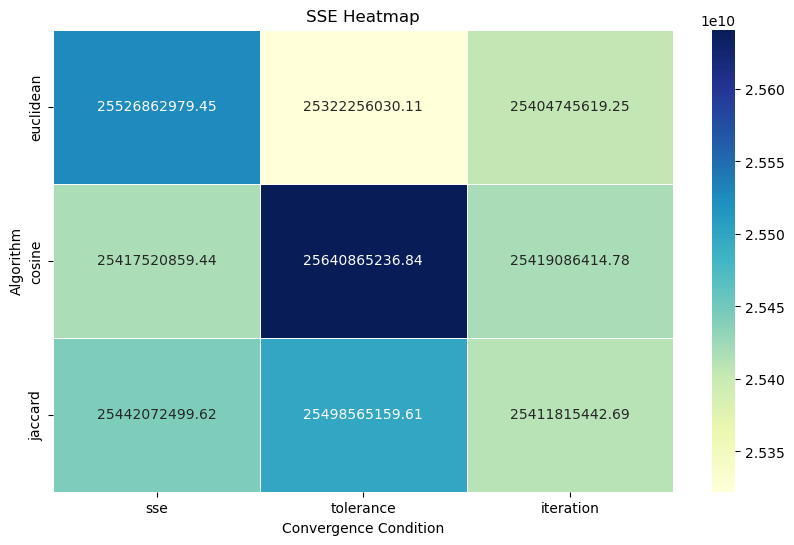

In [14]:
algorithms = ['euclidean', 'cosine', 'jaccard']
convergence_conditions = ['sse', 'tolerance', 'iteration']

sse_table = pd.DataFrame(index=algorithms, columns=convergence_conditions)

for algorithm in algorithms:
    for condition in convergence_conditions:
        _, _, _, _, sse = kmeans(X, k=10, similarity_measure=algorithm, convergence_condition=condition)
        sse_table.at[algorithm, condition] = sse

sse_table = sse_table.astype(float)
plt.figure(figsize=(10, 6))
sns.heatmap(sse_table, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("SSE Heatmap")
plt.xlabel("Convergence Condition")
plt.ylabel("Algorithm")
plt.show()

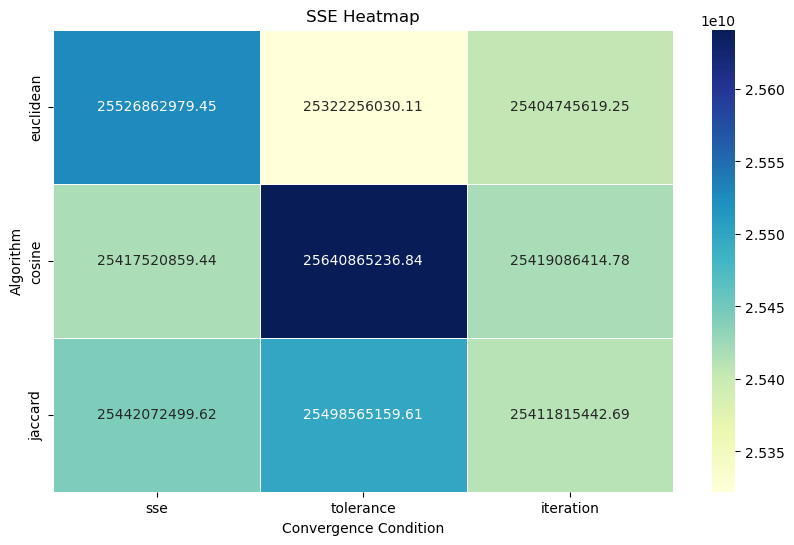